In [371]:
import pandas as pd
import seaborn as sns
import statsmodels as sm
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [380]:
df = pd.read_csv('../datasets/BTCHISTORICAL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Low'] = df['Low'].str.replace(',','')
df['Low'] = pd.to_numeric(df['Low'])

In [381]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-08-20,"10,728.8","10,911.2","10,941.6",10581.0,530.49K,-1.67%
1,2019-08-19,"10,910.7","10,312.8","10,923.9",10267.8,519.01K,5.80%
2,2019-08-18,"10,312.7","10,219.3","10,494.9",10086.7,441.11K,0.93%
3,2019-08-17,"10,218.1","10,335.5","10,460.7",10016.3,497.77K,-1.14%
4,2019-08-16,"10,335.6","10,300.9","10,734.0",9788.6,798.67K,0.31%


In [382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858 entries, 0 to 1857
Data columns (total 7 columns):
Date        1858 non-null datetime64[ns]
Price       1858 non-null object
Open        1858 non-null object
High        1858 non-null object
Low         1858 non-null float64
Vol.        1858 non-null object
Change %    1858 non-null object
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 101.7+ KB


In [383]:
df.describe()

,Low
count,1858.000000
mean,3181.552960
std,3624.915519
min,157.300000
25%,387.925000
50%,948.100000
75%,6090.300000
max,18750.900000


In [384]:
df = df.iloc[::-1]

In [385]:
df = df[(df['Date'] > '2018-06-01')]

In [386]:
df_low = df[['Date', 'Low']]
df_low.head()

,Date,Low
444,2018-06-02,7467.9
443,2018-06-03,7611.3
442,2018-06-04,7468.4
441,2018-06-05,7391.0
440,2018-06-06,7504.4


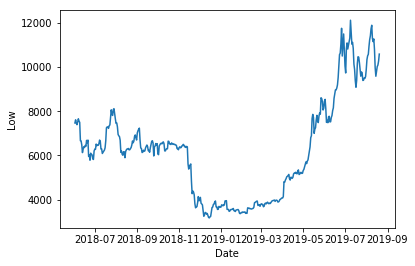

In [387]:
graph = sns.lineplot(x='Date', y='Low', data=df_low)

## Split on train and test

In [388]:
df_low_train = df_low[(df_low['Date'] < '2019-08-15')]
df_low_test = df_low[(df_low['Date'] > '2019-08-15')]

## Stationary

In [389]:
from statsmodels.tsa.stattools import adfuller
df.dropna(inplace=True)
adfuller(df_low_train['Low'])

(-0.6210024479588934,
 0.8661653663099198,
 15,
 423,
 {'1%': -3.4459042013025836,
  '5%': -2.8683970525583358,
  '10%': -2.5704225783970176},
 5777.0750236492495)

In [390]:
df_low_train['LowDiff'] = df_low_train['Low'] - df_low_train['Low'].shift(1)
df_low_train.dropna(inplace=True)

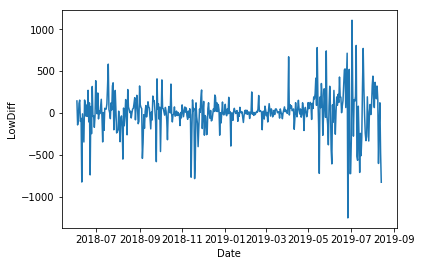

In [391]:
g = sns.lineplot(x='Date', y='LowDiff', data = df_low_train)

In [392]:
adfuller(df_low_train['LowDiff'])

(-5.255433813122537,
 6.767953862578064e-06,
 14,
 423,
 {'1%': -3.4459042013025836,
  '5%': -2.8683970525583358,
  '10%': -2.5704225783970176},
 5762.142019750931)

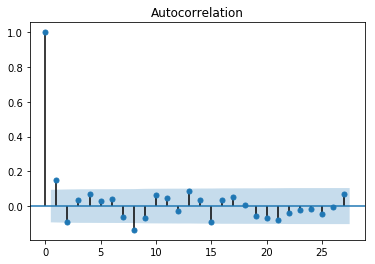

In [393]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt

plot_acf(df_low_train['LowDiff'])
plt.show()
#start value for q is 20

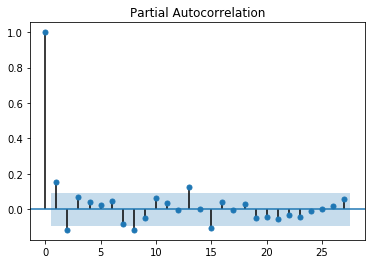

In [394]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_low_train['LowDiff'])
plt.show()
#start value for p is 20

In [395]:
#No need in building SARIMA model, because we don't have seasonal activity
from statsmodels.tsa.arima_model import ARIMA
best_aic = 1000000
best_arima = None
for p in range(1, 7):
    for q in range(1, 7):
        for d in range(0, 3):
            try:
                arima = ARIMA(df_low_train['Low'], order=(p,d,q)) #no need if differentiation, because our serie is stationary already
                arima_fit = arima.fit(disp=0)
                print(arima_fit.aic)
                if best_aic > arima_fit.aic:
                    best_arima = arima_fit
                    best_aic = arima_fit.aic
            except ValueError:
                continue



6037.1184648319795
6017.385722039826
6014.153756289921
6035.693300012541
6018.637740076967
6009.906521719056
6037.596373825263
6010.937509795907
6036.38588251647
6012.3782321807785
6037.541390949356
6038.631869060864
6036.247569790676
6018.2926172342595
6009.549195287797
6037.655482978411
6019.216199341032
6010.540485479127
6007.166667459229
6011.620540189113
6010.2571874942505
6006.264321295676
6003.647936999534
6037.345398049696
6018.568417695275
6009.879103358033
6038.199726170249
6009.8918210187185
6012.743950851107
6008.851730897941
6011.960520974792
6010.510525211673
6037.153453757979
6020.412121418933
6011.307452127407
6038.634442148299
6021.903889702453
6013.213883816038
6035.573188788978
6010.8509754466395
6005.610805878986
6012.362898810623
6011.031316539916
6040.022602513709
6022.346421681545
6013.143501648287
6040.917753842326
6024.662562798312
6014.981245791112
6031.594741719744
nan
6003.992867126559
6031.102826661892
6008.240413749263
6041.183100319524
6023.033865644109
6

In [269]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(best_arima.resid)
print(lb[1])
##Pretty big values means, that model took almost all data, which is good

[0.87909555 0.98556762 0.99822728 0.86740166 0.66926232 0.78062303
 0.43200665 0.25306921 0.29691029 0.35209499 0.3393405  0.22744207
 0.21405878 0.20027042 0.20831248 0.25974557 0.31835186 0.36664844
 0.33544851 0.36675961 0.30338967 0.35743667 0.34187509 0.39426895
 0.37851868 0.43284819 0.46132286 0.34824278 0.34397648 0.38837098
 0.43763164 0.4866057  0.48281677 0.50688093 0.55016613 0.59037391
 0.62837604 0.67187962 0.71164069 0.74674441]


In [396]:
best_arima.aic

6003.647936999534

In [397]:
best_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D2.Low   No. Observations:                  436
Model:                 ARIMA(2, 2, 6)   Log Likelihood               -2991.824
Method:                       css-mle   S.D. of innovations            229.378
Date:                Tue, 20 Aug 2019   AIC                           6003.648
Time:                        19:05:45   BIC                           6044.424
Sample:                             2   HQIC                          6019.740
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1532      0.104      1.474      0.141      -0.050       0.357
ar.L1.D2.Low     1.1492      0.040     28.378      0.000       1.070       1.229
ar.L2.D2.Low    -0.8872      0.060    -14.792      0.000      -1.005      -0.770
ma.L1.D2.Low    -1.9982      0.064    -31.109      0.000      -2.124      -1.872
ma.L2.D2.Low     1.6205      0.141     11.473      0.000       1.344       1.897
ma.L3.D2.Low    -0.3321      0.141     -2.349      0.019      -0.609      -0.055
ma.L4.D2.Low    -0.3335      0.128     -2.615      0.009      -0.583      -0.084
ma.L5.D2.Low     0.0553      0.118      0.468      0.640      -0.176       0.287
ma.L6.D2.Low    -0.0118      0.058     -0.203      0.839      -0.126       0.102
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6477           -0.8412j            1.0617           -0.1456
AR.2            0.6477           +0.8412j            1.0617            0.1456
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2            0.6476           -0.7860j            1.0185           -0.1403
MA.3            0.6476           +0.7860j            1.0185            0.1403
MA.4           -2.5000           -0.0000j            2.5000           -0.5000
MA.5            2.4425           -5.1648j            5.7132           -0.1797
MA.6            2.4425           +5.1648j            5.7132            0.1797
-----------------------------------------------------------------------------
"""

In [398]:
f = best_arima.forecast(len(df_low_test.values))[0]
f

array([9877.19592283, 9859.888828  , 9739.76597792, 9674.93068709,
       9764.96006384])

In [399]:
df_low_test

,Date,Low
4,2019-08-16,9788.6
3,2019-08-17,10016.3
2,2019-08-18,10086.7
1,2019-08-19,10267.8
0,2019-08-20,10581.0


In [400]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history

In [406]:
pr = best_arima.predict()
pr

441      0.153170
440    -23.086149
439   -118.996446
438   -140.407011
437     49.729319
          ...    
10    -225.112823
9      509.471885
8      289.296485
7       16.792884
6      455.237916
Length: 436, dtype: float64

In [404]:
len(df_low_train)

438

In [407]:
pr_undiff = []
for i in range(len(pr)):
    pr_undiff.append(inverse_difference(df_low_train['Low'][441-i], pr[441-i]))

In [409]:
pr_undiff.append(df_low_train['Low'][7])
pr_undiff.append(df_low_train['Low'][6])

In [410]:
pr_undiff.reverse()

In [411]:
pr_undiff

[9965.5,
 10793.2,
 10420.737916123993,
 10809.992883846111,
 11556.596485179942,
 11655.571884929985,
 11056.487177124402,
 11564.25189841639,
 11619.078004478524,
 11270.820844847569,
 11114.197536838437,
 10989.776389844135,
 10378.43504815143,
 10024.825469127112,
 9992.023749469026,
 9865.910334876831,
 9698.288462152703,
 9536.578644253163,
 9603.727731727584,
 9653.61130306537,
 9285.795546177384,
 9503.244448939013,
 10063.753766702017,
 10002.05003312477,
 10213.166341208864,
 10294.77166240545,
 10149.551751741117,
 9789.294854968663,
 9928.937898177051,
 9690.517817045182,
 9490.698615447749,
 9608.13831261471,
 10486.162282170582,
 10344.843212059193,
 10863.549440662082,
 11733.600659295449,
 11417.918137305087,
 10945.701429526995,
 12008.4995038097,
 11231.343515529568,
 11040.407018763493,
 11220.148808159316,
 10488.578781761595,
 10260.560686913946,
 11239.265584410567,
 10414.491171709398,
 10536.654939450189,
 10155.626865324824,
 11291.856148111863,
 12070.72039776

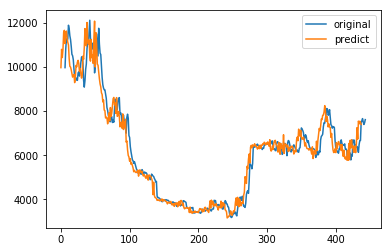

In [412]:
sns.lineplot(data=df_low_train['Low'], label="original")
sns.lineplot(data=pd.Series(pr_undiff), label="predict")

In [413]:
f = best_arima.forecast(len(df_low_test.values))[0]

In [414]:
f

array([9877.19592283, 9859.888828  , 9739.76597792, 9674.93068709,
       9764.96006384])

In [415]:
df_low_test.values

array([[Timestamp('2019-08-16 00:00:00'), 9788.6],
       [Timestamp('2019-08-17 00:00:00'), 10016.3],
       [Timestamp('2019-08-18 00:00:00'), 10086.7],
       [Timestamp('2019-08-19 00:00:00'), 10267.8],
       [Timestamp('2019-08-20 00:00:00'), 10581.0]], dtype=object)

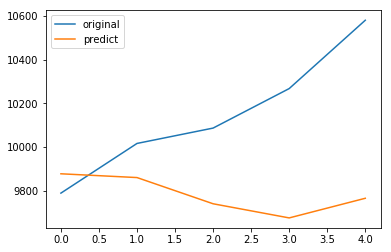

In [416]:
sns.lineplot(data=pd.Series(df_low_test['Low'].values), label="original")
sns.lineplot(data=pd.Series(f), label="predict")

In [422]:
f = best_arima.forecast(len(df_low_test.values) + 5)[0]

In [423]:
best_arima.conf_int()

,0,1
const,-0.050496,0.356836
ar.L1.D2.Low,1.069846,1.228594
ar.L2.D2.Low,-1.004708,-0.769612
ma.L1.D2.Low,-2.124124,-1.872332
ma.L2.D2.Low,1.343662,1.897329
ma.L3.D2.Low,-0.609213,-0.054951
ma.L4.D2.Low,-0.583490,-0.083576
ma.L5.D2.Low,-0.176299,0.286874
ma.L6.D2.Low,-0.125742,0.102117


In [425]:
f[len(df_low_test.values):]

array([ 9875.52346647, 10029.31852032, 10105.09427097, 10086.22626185,
       10027.92039732])